In [7]:
#!pip install mediapipe

ERROR: Could not find a version that satisfies the requirement mediapipe (from versions: none)
ERROR: No matching distribution found for mediapipe


In [52]:
#!pip install imageio-ffmpeg

## Importing libraries

In [51]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
#from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import imageio

## downloading the dataset

In [6]:
#!wget http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

--2023-02-17 11:41:33--  http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip
Resolving www.cbsr.ia.ac.cn (www.cbsr.ia.ac.cn)... 159.226.21.60
Connecting to www.cbsr.ia.ac.cn (www.cbsr.ia.ac.cn)|159.226.21.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87413900 (83M) [application/x-zip-compressed]
Saving to: ‘AFLW2000-3D.zip’

AFLW2000-3D.zip     100%[===================>]  83.36M   329KB/s    in 4m 28s  

2023-02-17 11:46:02 (318 KB/s) - ‘AFLW2000-3D.zip’ saved [87413900/87413900]



## Unzip the file

In [ ]:
if os.path.isfile('/content/AFLW2000-3D.zip') == True:
  !unzip /content/AFLW2000-3D.zip

In [ ]:
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [2]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

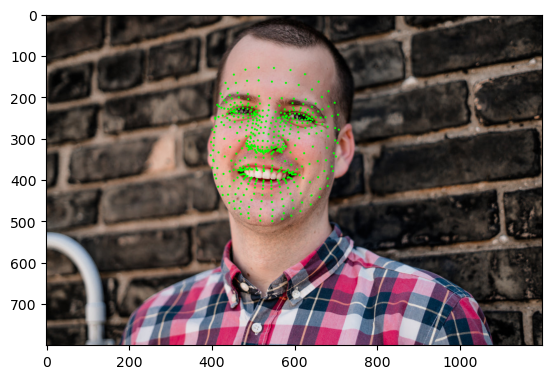

In [53]:
random_file = 'image00054'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('b.jpeg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.imshow(frame)

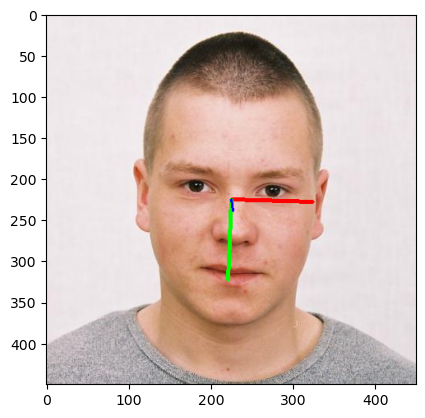

In [4]:
image = cv2.imread('AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
frame = cv2.cvtColor(draw_axis(image,pitch,yaw,roll), cv2.COLOR_BGR2RGB)
plt.imshow(frame)

In [5]:
directory = 'AFLW2000'

In [6]:
unique_names = []
for name in os.listdir(directory):
    if os.path.isfile(directory + '/' +name):
        unique_names.append(name[:-4])
unique_names = list(set(unique_names))
len(unique_names)

2000

In [ ]:
"""for name in unique_names:
    faceModule = mediapipe.solutions.face_mesh
    # loading image and its correspinding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
        image = cv2.imread('AFLW2000/'+name+'.jpg')
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
          # looping over the faces in the image
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = image.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                  #cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
        else:
            frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            print(name)
            plt.imshow(frame)
            plt.show()
            """

## get the size of the image

In [7]:
random_file = 'image00054'
image = cv2.imread('AFLW2000/'+random_file+'.jpg')
print(image.shape)

(450, 450, 3)


## Reading the data

In [8]:
# data = np.zeros((2000, 468*2))
features = []
output = []
# 468 is the number of landmarks in the image
i = 0
for filename in unique_names:
    image_name = directory + '/' + filename + '.jpg'
    # checking if it is a file
    
    faceModule = mediapipe.solutions.face_mesh
    # loading image and its correspinding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
        image = cv2.imread(image_name)
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
          # looping over the faces in the image
          landmarks = []
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = image.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  #data.append([relative_x, relative_y])
                  landmarks.append(relative_x)
                  landmarks.append(relative_y)
                  # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                  #cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
          features.append(landmarks)
          i+=1
          mat = directory + '/' + filename + '.mat'
          mat_file = sio.loadmat(mat)
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          pitch = pose_para[0]
          yaw = pose_para[1]
          roll = pose_para[2]
          output.append([pitch, yaw, roll])
          #cv2_imshow(image)        

In [9]:
features_np = np.array(features)
output_np = np.array(output)

In [10]:
features_np.shape

(1853, 936)

In [11]:
output_np.shape

(1853, 3)

### Note that OpenCV can't extract the landmarks of all images. the size of the data is less that 2000. It is 1853

In [ ]:
"""i = 0
output = np.zeros((2000, 3))
for filename in unique_names:
    f = directory + '/' + filename + '.mat'
    mat_file = sio.loadmat(f)
    # extracting the labels 3 angels
    pose_para = mat_file["Pose_Para"][0][:3]
    pitch = pose_para[0]
    yaw = pose_para[1]
    roll = pose_para[2]
    output[i] = [pitch, yaw, roll]
    i+=1"""

Splitting data into train, validation and test

In [12]:
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(
    features_np, output_np, test_size=0.4, random_state=100)

In [13]:
features_validation, features_test, labels_validation, labels_test = train_test_split(
    features_validation_test, labels_validation_test, test_size=0.5, random_state=100)

## Building the model

## Linear regression

In [14]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
# fit model
model.fit(features_train, labels_train)
print('training : ', model.score(features_train, labels_train))
model.score(features_validation, labels_validation)

training :  0.9332053010172242


-9.024683146380447

## KNN

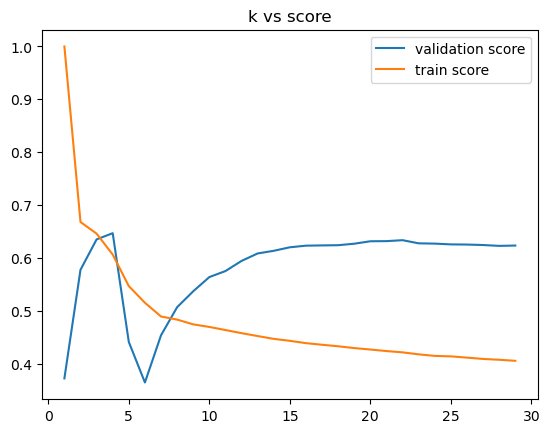

In [15]:
from sklearn.neighbors import KNeighborsRegressor
k = range(1, 30)
train_score = []
validation_score = []
for i in k:
  model = KNeighborsRegressor(n_neighbors=i)
  model.fit(features_train, labels_train)
  train_score.append(model.score(features_train, labels_train))
  validation_score.append(model.score(features_validation, labels_validation))
plt.plot(list(k), validation_score, label='validation score')
plt.plot(list(k), train_score, label='train score')
plt.title("k vs score")
plt.legend()
plt.show()

In [25]:
model_nn = KNeighborsRegressor(n_neighbors=4)
model_nn.fit(features_train, labels_train)
print('train score : ', model_nn.score(features_train, labels_train))
print('validation score : ', model_nn.score(features_validation, labels_validation))

train score :  0.6063756471491504
validation score :  0.6468324633069136


## Decision tree

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':[3, 4, 5, 6, 7], 'min_samples_leaf':[20, 10, 30, 35]}
model = DecisionTreeRegressor(random_state=100)
clf = GridSearchCV(model, parameters)
clf.fit(features_train, labels_train)
print('training : ', clf.best_estimator_.score(features_train, labels_train))
print('validation : ', clf.best_estimator_.score(features_validation, labels_validation))
print(clf.best_params_)

training :  0.38524561892708986
validation :  0.46664908737764127
{'max_depth': 7, 'min_samples_leaf': 20}


## random forest

In [18]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(features_train, labels_train)
print('validation : ', regr.score(features_validation, labels_validation))

validation :  0.22900265823006652


## Testing the model

In [19]:
random_file = 'image00054'
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')

[ WARN:0@197.792] global loadsave.cpp:244 findDecoder imread_('/content/AFLW2000/image00054.jpg'): can't open/read file: check file path/integrity


In [10]:
"""cap = cv2.VideoCapture('video.mp4')
if (cap.isOpened()== False):
    print("Error opening video file")
  
# Read until video is completed
while(cap.isOpened()):
      
# Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
    # Display the resulting frame
        cv2.imshow('Frame', frame)
          
    # Press Q on keyboard to exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
  
# Break the loop
    else:
        break
  
# When everything done, release
# the video capture object
cap.release()
  
# Closes all the frames
cv2.destroyAllWindows()"""

In [21]:
def extract_landmarks(image, hide=False, i = 0, save_on_disk = False, distination=None, video= False, form=None, file_name=None):
    xx = []
    yy = []
    simple_test_features = []
    # checking if it is a file
    image = cv2.resize(image, (450, 450))
    faceModule = mediapipe.solutions.face_mesh
    # loading image and its correspinding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image

        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
          # looping over the faces in the image
          landmarks = []
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = image.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  #data.append([relative_x, relative_y])
                  landmarks.append(relative_x)
                  landmarks.append(relative_y)
                  xx.append(relative_x)
                  yy.append(relative_y)
                  # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                  if hide == False and save_on_disk == False:
                    cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
          #frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          if save_on_disk == False and hide == False:
              plt.imshow(frame) 
          elif save_on_disk == True:
              if video:
                  plt.savefig(distination + str(i)+'.'+form)
              else:
                  plt.savefig(distination + file_name +'.'+form)
          simple_test_features.append(landmarks)
          simple_test_features = np.array(simple_test_features)
    return simple_test_features, image, xx, yy

In [41]:
def show_prediction(model, simple_test_features, image, x, y, i=0, save_on_disk = False, distination=None, video= False, form=None, file_name=None):
    prediction = model.predict(simple_test_features)
    print(prediction)
    pitch = prediction[0][0]
    yaw = prediction[0][1]
    roll = prediction[0][2]
    
    center_x = min(x) + (max(x)-min(x))/2
    center_y = min(y) + (max(y)-min(y))/2
    frame = cv2.cvtColor(draw_axis(image,pitch,yaw,roll,  tdx=center_x, tdy=center_y), cv2.COLOR_BGR2RGB)
    if save_on_disk == False:
        plt.imshow(frame) 
    else:
        if video:
            plt.imshow(frame) 
            plt.savefig(distination + str(i)+'.'+form)
            #plt.show()
        else:
            plt.savefig(distination + file_name +'.'+form)
            plt.show()
    #cv2.imshow("w", draw_axis(image,pitch,yaw,roll))
    #cv2.waitKey(0)

## Reading an image and predict

[[ 0.30574145 -0.48956053  0.07158158]]


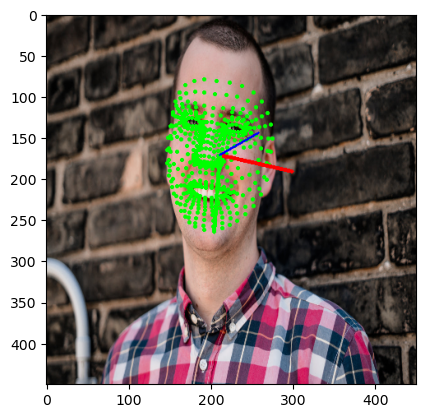

In [54]:
filename = 'b.jpeg'
# step 1
image = cv2.imread(filename)
#step2
landmarks, image, x, y = extract_landmarks(image)

#step 3
show_prediction(model_nn, landmarks, image,  x, y)

## Reading a video and predicting and then saving the output to images

In [ ]:
from IPython import display
%matplotlib inline

cap = cv2.VideoCapture('video3.mp4')
i = 0
while(cap.isOpened()):
    try:
        ret, frame = cap.read()
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        landmarks, image, x, y = extract_landmarks(frame, i)
        i+=1
        #print(landmarks)
        #plt.imshow(frame)
        
        if len(landmarks)>0:
            #print(landmarks)
            show_prediction(model_nn, landmarks, image, i, x, y)
        else:
            frame = cv2.resize(frame, (450, 450))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.imshow(frame)
            plt.savefig('movie/'+str(i)+'_.png')
        
        #display.clear_output(wait=True)
        #display.display(plt.gcf())

    except KeyboardInterrupt:
        cap.release()

## convert images into video

In [109]:
frameSize = (450, 450)

writer = imageio.get_writer('test.mp4', fps=20)


number_of_images = len([name for name in os.listdir('movie') if name.endswith('.png')])
for i in range(1, number_of_images):
    writer.append_data(imageio.imread('movie/' +str(i) + '_.png'))
writer.close()

## recording from camera

In [ ]:
cap = cv2.VideoCapture(0)
i = 0
distination ='camera/'
form = 'jpeg'
while cap.isOpened():
    success, image = cap.read()
    
    landmarks, image, x, y = extract_landmarks(image, hide = True)
    #step 3
    if len(landmarks) > 0:
        show_prediction(model_nn, landmarks, image,  x, y, i=i, save_on_disk = True, distination = distination, video= True, form = form)
    elif len(landmarks) == 0:
        plt.imshow(image) 
        plt.savefig(distination + str(i)+'.'+form)
    i+=1
    if not success:
        break
    cv2.imshow("My video capture", cv2.flip(image, 1))
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [50]:
frameSize = (450, 450)

writer = imageio.get_writer('project.mp4', fps=10)

number_of_images = len([name for name in os.listdir('camera') if name.endswith('.jpeg')])
for i in range(1, number_of_images):
    writer.append_data(imageio.imread('camera/' +str(i) + '.jpeg'))
writer.close()